In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# ===========================================================================
# Calculation of geometric properties of boundary element segments
# ===========================================================================
def geometry(x_list,y_list,seg_list):
    Ns = np.sum(seg_list) # total no. of segments
    Np = Ns+1 # total no. of segment end-points
    
    lb = np.sqrt((x_list[1:]-x_list[:-1])**2 + (y_list[1:]-y_list[:-1])**2)

    # total no. of segments at the beginning of each boundary element
    seg_num = np.zeros(seg_list.size)
    for i in range(1,seg_list.size):
        seg_num[i] = seg_num[i-1] + seg_list[i-1]

    x, y = [np.zeros(Np) for i in range(2)]
    x[0] = x[-1] = x_list[0]; y[0] = y[-1] = y_list[0]
    for i in range(seg_list.size):
        x[seg_num[i]:seg_num[i]+seg_list[i]+1] = np.linspace(x_list[i],x_list[i+1],seg_list[i]+1)
        y[seg_num[i]:seg_num[i]+seg_list[i]+1] = np.linspace(y_list[i],y_list[i+1],seg_list[i]+1)

    # mid-pt of segments
    xm = 0.5*(x[1:] + x[:-1])
    ym = 0.5*(y[1:] + y[:-1])

    # list of mid-pts by boundary element index
    xms, yms = [[0]*seg_list.size for i in range(2)] # sequence with 1 element for each segment 
    for i in range(seg_list.size):
        xms[i] = np.array(xm[seg_num[i]:seg_num[i]+seg_list[i]])
        yms[i] = np.array(ym[seg_num[i]:seg_num[i]+seg_list[i]])

    # length of segments
    l = np.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)

    # normal vectors
    ny = (x[:-1] - x[1:])/l
    nx = (y[1:] - y[:-1])/l        

    return x, y, xm, ym, xms, yms, nx, ny, l, Ns, seg_num, lb

In [4]:
# ===========================================================================
# Setting boundary conditions for each segement of boundary element
# ===========================================================================
def setBC(bct,bcv,seg_list,seg_num):
    BCT, BCV = [np.zeros(Ns) for i in range(2)]
    for i in range(seg_list.size):
        BCT[seg_num[i]:seg_num[i]+seg_list[i]] = bct[i]
        BCV[seg_num[i]:seg_num[i]+seg_list[i]] = bcv[i]
        
    return BCT, BCV


In [5]:
# ===========================================================================
# Calculate integral coefficients F1 & F2 for a given array of points (x0,y0)
# ===========================================================================
def F1F2(x0,y0,x,y,l,nx,ny):    
    k = int(Ns) # no. of segments
    s = x0.size # no. of points

    A, B, E, F1, F2 = [np.zeros((k,s)) for i in range(5)]
    k = np.arange(k)
    s = np.arange(s)    
    K, S = np.meshgrid(k,s)
    
    A[K,:] = np.square(l[K]).T
    B[K,S] = 2*l[K]*(-(x[K]-x0[S])*ny[K] + (y[K]-y0[S])*nx[K])
    E[K,S] = (x[K]-x0[S])**2 + (y[K]-y0[S])**2

    M = 4*A*E - B**2
    D = 0.5*B/A
    
    zero = 1e-10 # a very small number to take care of floating point errors
    # Jth point (x0[J],y0[J]) intersects the (extended) Ith line segment
    I,J = np.where(M<zero)
    # jth point (x0[j],y0[j]) does not intersect (extended) ith line segment
    i,j = np.where(M>zero)

    # for M = 0 (lim D->0 D*ln(D)=0 )
    # since the log function cannot handle log(0), 'zeros' have been added to log(D) -> log(D+zero)
    F1[I,J] = 0.5*l[I]*(np.log(l[I]) \
                          + (1 + D[I,J])*np.log(np.abs(1 + D[I,J]) + zero) \
                          - D[I,J]*np.log(np.abs(D[I,J] + zero)) - 1)/np.pi
    # for M > 0
    H = np.arctan((2*A[i,j]+B[i,j])/np.sqrt(M[i,j])) - np.arctan(B[i,j]/np.sqrt(M[i,j]))
    F1[i,j] = 0.25*l[i]*(2*(np.log(l[i]) - 1) \
                           - D[i,j]*np.log(np.abs(E[i,j]/A[i,j])) \
                           + (1 + D[i,j])*np.log(np.abs(1 + 2*D[i,j] + E[i,j]/A[i,j])) \
                           + H*np.sqrt(M[i,j])/A[i,j])/np.pi
    F2[i,j] = l[i]*(nx[i]*(x[i] - x0[j]) + ny[i]*(y[i] - y0[j]))*H/np.sqrt(M[i,j])/np.pi

    return F1.T, F2.T

In [6]:
# ===========================================================================
# Build matrix system from F1 & F2 to find remaining BCs 
# ===========================================================================
def pqBC(F1,F2,BCT,BCV):
    Ns = BCT.size
    F2x = F2 - 0.5*np.eye(Ns)
    a,b = [np.zeros((Ns,Ns)) for i in range(2)]

    # phi is known - d(phi)/dn is unknown
    col_p = np.where(BCT==0)
    a[:,col_p] = -F1[:,col_p]
    b[:,col_p] = -F2x[:,col_p]
    # d(phi)/dn is known - phi is unknown
    col_q = np.where(BCT==1)
    a[:,col_q] = F2x[:,col_q]
    b[:,col_q] = F1[:,col_q]

    BCV2 = np.linalg.solve(a,np.dot(b,BCV))

    p = BCV2.copy()
    q = BCV2.copy()

    p[col_p] = BCV[col_p] # replace with known 'phi's
    q[col_q] = BCV[col_q] # replace with known 'd(phi)/dn's

    return p, q


/Users/cdohl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cdohl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cdohl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cdohl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cdohl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


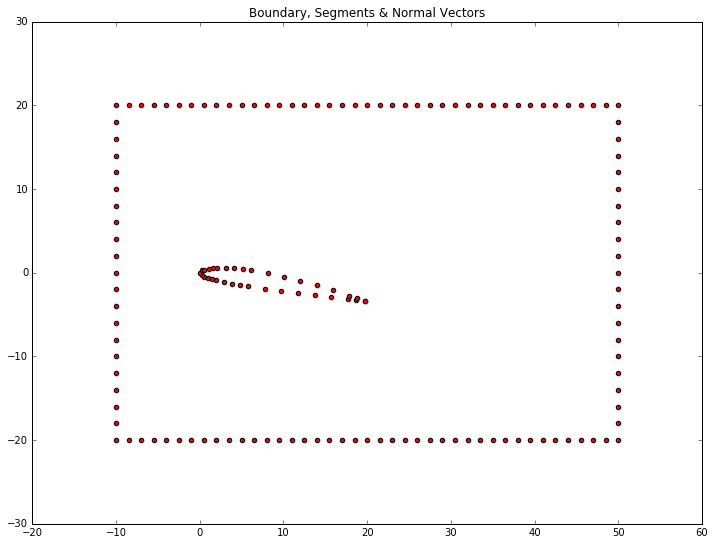

In [38]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# GEOMETRY
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# (x,y)       segment end-points
# (xm, ym)    segment mid-points
# (xms,yms)   segment mid-point grouped by boundary elements
# (nx,ny)     normal vector components centered at (xm,ym)
# l           segment lengths
# Ns          total no. of segments
# seg_num     total no. of segments at the end of each boundary element
# lb          length of boundary element

# End-point coordinates of external rectangular domain (anti-clockwise / last pt = first pt)
x_list1 = np.array([-10.,50.,50.,-10.,-10.])
y_list1 = np.array([-20.,-20.,20,20,-20])
# No. of segments for each boundary element
seg_list1 = np.array([40,20,40,20])
# Indices
inlet = 3 # inlet
outlet = 1 # outlet

# Coordinates of airfoil (clockwise / last pt = first pt)
scale =  20
x_list2 = scale*np.array([1.00000, 0.95041, 0.90067, 0.80097, 0.70102, 0.60085, 
                    0.50049, 0.40000, 0.29875, 0.24814, 0.19761, 0.14722, 
                    0.09710, 0.07217, 0.04742, 0.02297, 0.01098, 0.00000, 
                    0.01402, 0.02703, 0.05258, 0.07783, 0.10290, 0.15278, 
                    0.20239, 0.25186, 0.30125, 0.40000, 0.49951, 0.59915, 
                    0.69898, 0.79903, 0.89933, 0.94959, 1.00000, 1.00000])[::-1] # clockwise
y_list2 = scale*np.array([0.00105,  0.00990,  0.01816,  0.03296,  0.04551,  0.05580,
                       0.06356,  0.06837,  0.06875,  0.06668,  0.06276,  0.05665,  
                       0.04766,  0.04169,  0.03420,  0.02411,  0.01694,  0.00000, 
                       -0.01448, -0.01927, -0.02482, -0.02809, -0.03016, -0.03227, 
                       -0.03276, -0.03230, -0.03125, -0.02837, -0.02468, -0.02024, 
                       -0.01551, -0.01074, -0.00594, -0.00352, -0.00105, 0.00105])[::-1] # clockwise
alpha = 10 # angle of attack
D2R = np.pi/180
rot = np.array([np.cos(alpha*D2R), -np.sin(alpha*D2R), np.sin(alpha*D2R), np.cos(alpha*D2R)]).reshape(2,2)
x_list2 = np.dot(np.c_[x_list2,y_list2],rot)[:,0]
y_list2 = np.dot(np.c_[x_list2,y_list2],rot)[:,1]
Ns2 = x_list2.size - 1
seg_list2 = np.ones(Ns2)
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

x1, y1, xm1, ym1, xms1, yms1, nx1, ny1, l1, Ns1, seg_num1, lb1 = geometry(x_list1,y_list1,seg_list1)
x2, y2, xm2, ym2, xms2, yms2, nx2, ny2, l2, Ns2, seg_num2, lb2 = geometry(x_list2,y_list2,seg_list2)

# Combining the internal & external boundaries
x = np.append(x1[:-1],x2[:-1])
y = np.append(y1[:-1],y2[:-1])
xm = np.append(xm1,xm2)
ym = np.append(ym1,ym2)
l = np.append(l1,l2)
nx = np.append(nx1,nx2)
ny = np.append(ny1,ny2)
Ns = Ns1 + Ns2
seg_list = np.append(seg_list1,seg_list2)
seg_num = np.zeros(seg_list.size)
for i in range(1,seg_list.size):
    seg_num[i] = seg_num[i-1] + seg_list[i-1]

fig = plt.figure(figsize=(12,12),dpi=100)
fig.add_subplot(111,aspect='equal')
plt.scatter(x,y,c=u'r',marker=u'o')
#plt.scatter(xm,ym,c=u'g',marker=u'^')
#plt.quiver(xm,ym,nx,ny)
plt.title('Boundary, Segments & Normal Vectors')
plt.show()

In [39]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# BOUNDARY CONDITIONS
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
U = 1. # volume flow rate
bct = np.ones(Ns) # sequence of boundary condition types: 0->p, 1->q
bcv = np.zeros(Ns) # sequence of boundary condition values
bcv[inlet]  = -U/lb1[inlet]
bcv[outlet] =  U/lb1[outlet]
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

BCT, BCV = setBC(bct,bcv,seg_list,seg_num)

F1, F2 = F1F2(xm,ym,x,y,l,nx,ny) # obtaining F1 & F2 for segment mid-points
p, q = pqBC(F1,F2,BCT,BCV) # solving for additional boundary conditions

/Users/cdohl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cdohl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cdohl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cdohl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


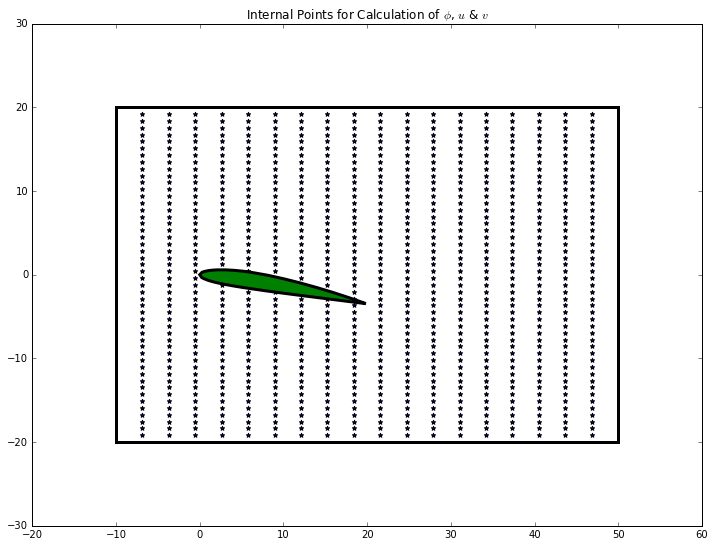

In [40]:
# Generating internal points (excludes boundary)
Nx = 20; Ny = 50;
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

X = np.linspace(x.min(),x.max(),Nx)
Y = np.linspace(y.min(),y.max(),Ny)
XX,YY = np.meshgrid(X[1:-1],Y[1:-1])

X = XX.ravel(); Y = YY.ravel()

# Determines points within airfoil region by computing dot product [D] of
# normal vectors and vectors from mid-points on airfoil surface to points 
# of interest. If all the dot products are positive, point of interest 
# lies within the airfoil. Also, removes points on the outside which are a
# with a certain minimum distance [L] from the airfoil.
D = np.zeros((X.size,xm2.size))
L = np.zeros((X.size,xm2.size))
I = []
for i in range(X.size):
    for j in range(xm2.size):
        D[i,j] = (X[i]-xm2[j])*nx2[j] + (Y[i]-ym2[j])*ny2[j]
        L[i,j] = np.sqrt((X[i] - xm2[j])**2 + (Y[i] - ym2[j])**2)
    if ((D[i,:]>0).all()):
        I.append(i)
    elif ((L[i,:]<1).any()):
        I.append(i)
        
#X = np.delete(X.ravel(),I)
#Y = np.delete(Y.ravel(),I)

fig = plt.figure(figsize=(12,12),dpi=100)
fig.add_subplot(111,aspect='equal')
plt.fill(x1,y1,fill=False,lw=3)
plt.fill(x2,y2,fill=True,lw=3)
plt.scatter(X,Y,c=u'b',marker=u'*')
plt.title(r'Internal Points for Calculation of $\phi$, $u$ & $v$')
plt.show()

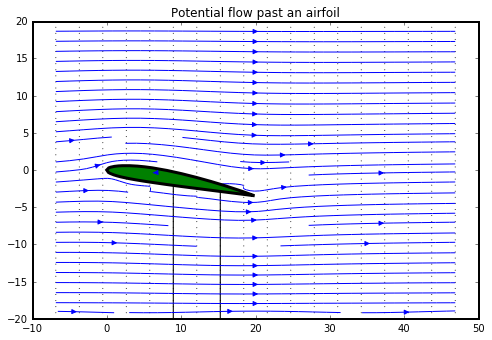

In [41]:
# Calculate velocity (u,v) at internal grid points (X,Y)
# ===========================================================================
delta_x = delta_y = 0.05
F1, F2 = F1F2(X+delta_x,Y,x,y,l,nx,ny)
phi_x_plus = (np.dot(F2,p) - np.dot(F1,q))
F1, F2 = F1F2(X-delta_x,Y,x,y,l,nx,ny)
phi_x_minus = (np.dot(F2,p) - np.dot(F1,q))
F1, F2 = F1F2(X,Y+delta_y,x,y,l,nx,ny)
phi_y_plus = (np.dot(F2,p) - np.dot(F1,q))
F1, F2 = F1F2(X,Y-delta_y,x,y,l,nx,ny)
phi_y_minus = (np.dot(F2,p) - np.dot(F1,q))

# Central difference to determine velocity
u = 0.5*(phi_x_plus - phi_x_minus)/delta_x
v = 0.5*(phi_y_plus - phi_y_minus)/delta_y

fig = plt.figure(figsize=(8,8), dpi=100)
fig.add_subplot(111,aspect='equal')
plt.fill(x1,y1,fill=False,lw=3)
plt.fill(x2,y2,fill=True,lw=3)
plt.quiver(X,Y,u,v)
plt.streamplot(XX,YY,np.reshape(u,XX.shape),np.reshape(v,XX.shape))
plt.title('Potential flow past an airfoil')
plt.show()

In [31]:
u.shape

(840,)

In [32]:
XX.shape

(48, 18)

In [33]:
48*18

864